In [837]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [838]:
store_sales = pd.read_csv('seasonal_sales_dataset.csv')
store_sales.head(10)

,date,item,store,sales
0,2023-01-31,12,2,331
1,2023-12-30,42,5,267
2,2022-05-10,9,7,481
3,2023-07-18,15,4,339
4,2023-02-04,40,5,359
5,2022-12-31,25,1,279
6,2024-09-20,5,1,151
7,2022-11-10,11,15,133
8,2024-06-26,34,20,452
9,2020-05-01,24,19,492


check for null values in the data set

In [839]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2000 non-null   object
 1   item    2000 non-null   int64 
 2   store   2000 non-null   int64 
 3   sales   2000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 62.6+ KB


since we are only dealing with sales, we have to drop/disregard other integer datatypes or id except sales. But we have only one int datatype i.e.,sales, so we don't need to drop any columns/lines.

Still if you have to drop any line, you can use the code for reference:
store_sales = store_sales.drop(['Item','Store'],axis=1)

In [840]:
store_sales = store_sales.drop(['item','store'],axis=1)

In [841]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2000 non-null   object
 1   sales   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Converting date from object datatype to dateTime datatype.

In [842]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [843]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2000 non-null   datetime64[ns]
 1   sales   2000 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.4 KB


Converting Date to month period and then sum the items in each month.

In [844]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
print(store_sales['date'].dtype)

monthly_sales = store_sales.groupby('date').sum().reset_index()

period[M]


Convert the resulting date column to timestamp datatype.

In [845]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [846]:
monthly_sales.head(10)

,date,sales
0,2020-01-01,12963
1,2020-02-01,12572
2,2020-03-01,13568
3,2020-04-01,16218
4,2020-05-01,17437
5,2020-06-01,12766
6,2020-07-01,9743
7,2020-08-01,9424
8,2020-09-01,6563
9,2020-10-01,4181


Visualization

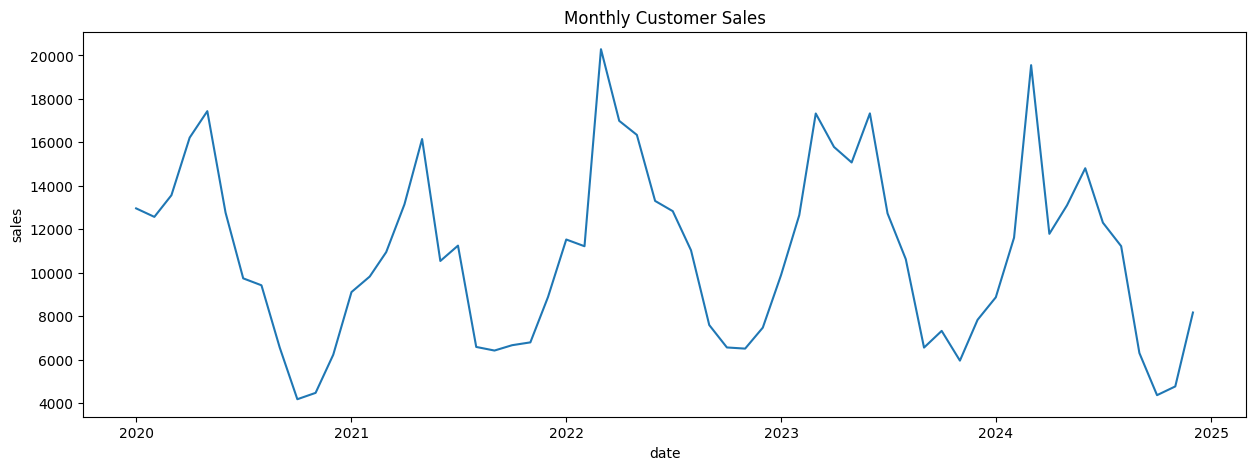

In [847]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("Monthly Customer Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationary.

In [848]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2020-02-01,12572,-391.0
2,2020-03-01,13568,996.0
3,2020-04-01,16218,2650.0
4,2020-05-01,17437,1219.0
5,2020-06-01,12766,-4671.0
6,2020-07-01,9743,-3023.0
7,2020-08-01,9424,-319.0
8,2020-09-01,6563,-2861.0
9,2020-10-01,4181,-2382.0
10,2020-11-01,4473,292.0


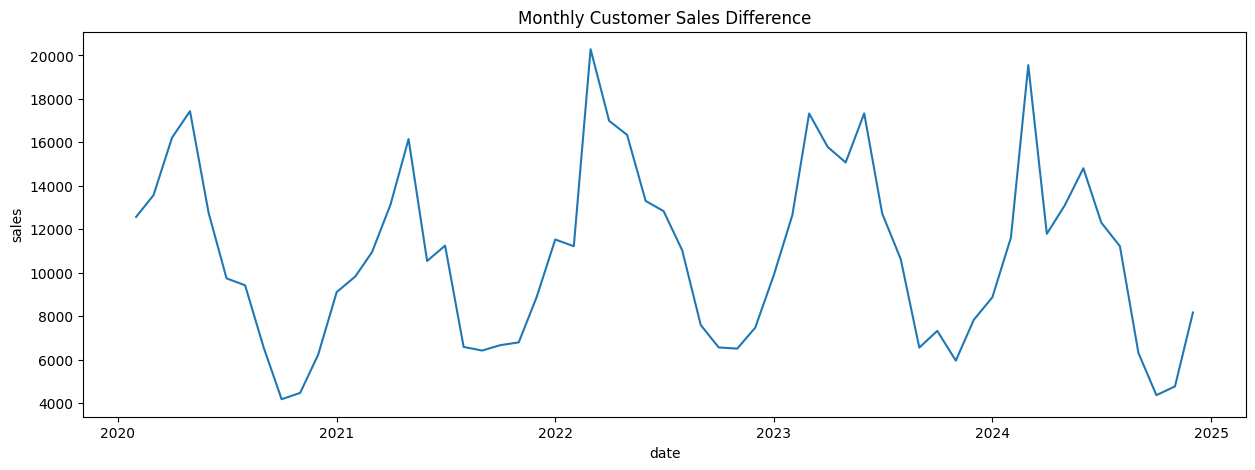

In [849]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("Monthly Customer Sales Difference")
plt.show()

Droping of Sales and Date. Because now we are using Stationary Sales data.

In [850]:
supervised_data = monthly_sales.drop(['sales', 'date'], axis =1)

preparing the supervised data.

In [851]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0,-4671.0,1219.0,2650.0,996.0,-391.0
1,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0,-4671.0,1219.0,2650.0,996.0
2,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0,-4671.0,1219.0,2650.0
3,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0,-4671.0,1219.0
4,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0,-4671.0
5,706.0,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0,-3023.0
6,-4662.0,706.0,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0,-319.0
7,-166.0,-4662.0,706.0,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0,-2861.0
8,246.0,-166.0,-4662.0,706.0,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0,-2382.0
9,130.0,246.0,-166.0,-4662.0,706.0,-5611.0,3007.0,2197.0,1124.0,714.0,2884.0,1755.0,292.0


split data into train and test.

In [852]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ",train_data.shape)
print("Test Data Shape: ",test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [853]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [854]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (35, 12)
y_train Shape:  (35,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sales price of all trained algs.

In [855]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [856]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[7835, 8872, 11616, 19554, 11792, 13105, 14810, 12305, 11225, 6307, 4368, 4770, 8171]


From here we use the Linear Regression.

To create the linear regression model and predicted output.

In [857]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

In [858]:
lr_pred = lr_pred.reshape(-1,1)
lr_pred_test_set = np.concatenate([lr_pred, X_test], axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)
#Above is a set matrix contains the input features of the test data and also the predicted output.

In [859]:
result_list = []
for index in range(0, len(lr_pred_test_set)):
    result_list.append(lr_pred_test_set[index][0] + act_sales[index])

lr_pre_series = pd.Series(result_list, name='Linear Regression')
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [860]:
#print(predict_df)
from sklearn.metrics import r2_score
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Regression'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Regression'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Regression'], monthly_sales['sales'][-12:])
print("Linear Regression MSE : ", lr_mse)
print("Linear Regression MAE : ", lr_mae)
print("Linear Regression R2 : ", lr_r2)

Linear Regression MSE :  2908.6420053230963
Linear Regression MAE :  2447.1298307754864
Linear Regression R2 :  0.454969324818183


Visualising the prediction against actual sales.

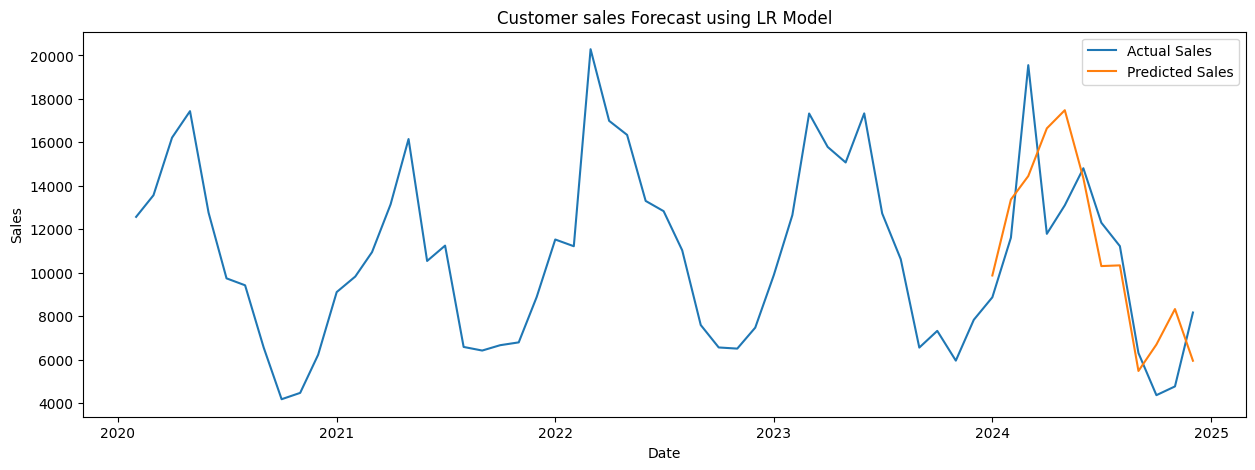

In [861]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales') #Actual Sales
#Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Regression'])
plt.title("Customer sales Forecast using LR Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()